# 今日の輪読の前提
第六章は「学習のためのテクニック」と題し、これまで学んできたニューラルネットワークの**学習**について、効率的な学習のためのアイデアを紹介する章です。  
これまで、最適な重みパラメータを探索する最適化手法（Momentum, AdaGrad, Adam）、重みパラメータの初期値（Xavierの初期値、Heの初期値）、Batch Normalization（初期値にロバストでも速い学習が可能）を紹介してきた。  
6月30日の輪読では、過学習の対応策である正則化手法と、ハイパーパラメータの設定方法を扱います。  

# 6.4 正則化（regularization）
## 過学習について
 p.189-190の内容は4.1.2（p.86-7）にも同様に記述されている。  
機械学習の最終的な目標は**汎化能力**〈まだ見ぬデータ・訓練データに含まれないデータ）に対しての能力〉を獲得することである。(p.87)  
あるデータセットだけに過度に対応した状態を**過学習**（overfitting）という。訓練データとは別のデータセットには対応できない過学習を避けることは、機械学習の重要な課題でもある。(p.87)  
## 正規化(normalization)と正則化（regularization）
正規化：データをある決まった範囲に変換する処理 (p.77)  
Batch Normalization（各ミニバッチ毎に入力データを平均0・分散1に正規化する）の例でわかったように、速い学習を可能にする前処理である。

正則化の定義はこの本ではなされていない（p.193が初出という認識だが合っているだろうか）。いきなり過学習の除去の話をしており、それこそが正則化の行いだと読み取れる。。  
つまり、「汎化能力を確保するために、過学習を避ける処理」ということになる。  
実際、言語処理学事典では以下のように述べている（論調は緩く定義とはいえないか）。  
>過適合に対処するための有効な方法として, 正則化と呼ばれる方法がある. これは, パラメータが特定の極端な事例に影響されて極端な値をとることを防ぐための「極端さに対するペナルティ関数」であるといえる.  
（言語処理学会編『言語処理学事典』共立出版, 2009年, p.228）

「正則」というと正則行列を思い浮かべるかもしれない。
正則行列とは以下で定義されている行列のことだった。つまり、逆行列を持つ正方行列(n×n型の行列)のこと。  
>*n*次行列*A*に対し、*XA＝AX＝E*となる行列*X*が存在するとき、*A*を正則行列と言う。このような*X*を*A*の逆行列と言う。  
(斎藤正彦『線形代数入門』東京大学出版会, 1966年, p.41)

斉藤は正則行列の英訳をnon-singular matrixとしている。直訳すると「非特異」。  
ちなみに、汎化性能・能力はgeneralizationである（言語処理学会編『言語処理学事典』共立出版, 2009年, p.228）。

# 6.4.1 過学習
過学習が起きる主要な原因は以下の二つ
* パラメータを大量に持ち、表現力の高いモデルであること
* 訓練データが少ないこと  

**↓まずは過学習を再現する↓** 
* 7層のネットワークで複雑性を高める
* 訓練データは300個のみ 

epoch:0, train acc:0.07666666666666666, test acc:0.0822
epoch:1, train acc:0.09, test acc:0.0835
epoch:2, train acc:0.1, test acc:0.0874
epoch:3, train acc:0.13333333333333333, test acc:0.1016
epoch:4, train acc:0.17666666666666667, test acc:0.1164
epoch:5, train acc:0.19333333333333333, test acc:0.1307
epoch:6, train acc:0.2, test acc:0.1418
epoch:7, train acc:0.21666666666666667, test acc:0.1491
epoch:8, train acc:0.22, test acc:0.1612
epoch:9, train acc:0.26, test acc:0.179
epoch:10, train acc:0.26666666666666666, test acc:0.1892
epoch:11, train acc:0.31, test acc:0.2051
epoch:12, train acc:0.35333333333333333, test acc:0.2178
epoch:13, train acc:0.39666666666666667, test acc:0.2398
epoch:14, train acc:0.41, test acc:0.2615
epoch:15, train acc:0.4, test acc:0.2575
epoch:16, train acc:0.46, test acc:0.3059
epoch:17, train acc:0.49333333333333335, test acc:0.3199
epoch:18, train acc:0.51, test acc:0.3399
epoch:19, train acc:0.5433333333333333, test acc:0.3675
epoch:20, train acc:0.576

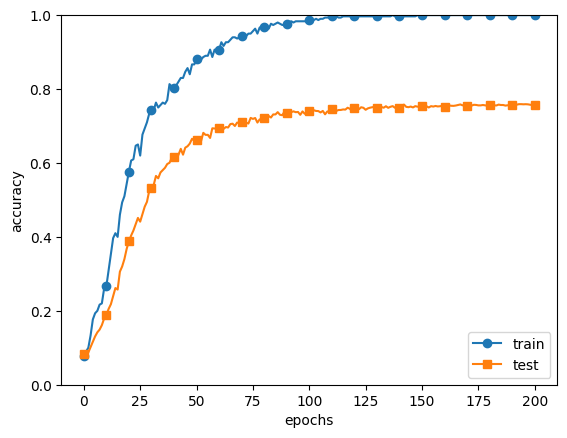

In [1]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10) #
optimizer = SGD(lr=0.01) #学習係数lr 0.01の確率的勾配降下法SGDでパラメータ更新

max_epochs = 201
train_size = x_train.shape[0] #300ですね。
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1) #300/100=3ですね。
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 6.4.2 Weight decay（荷重減衰）
重みのL2ノルムを損失関数に加算する方法。  
ノルムには非負性があるため、最小化しようとしている損失関数に加算することで、必ずペナルティとして機能することになる。  
↓画像は斎藤（p.212-3）より。

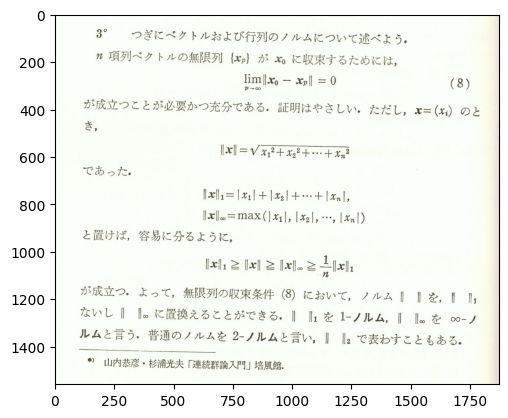

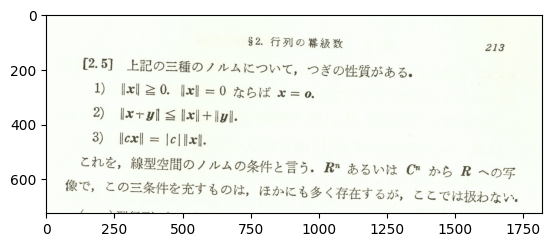

In [31]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img1 = imread('/Users/tmdukanzo/myproject/rio\'s atelier/dataset/masahiko.jpg') # 画像の読み込み
img2 = imread('/Users/tmdukanzo/myproject/rio\'s atelier/dataset/masahiko2.jpg') # 画像の読み込み

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

epoch:0, train acc:0.12, test acc:0.1088
epoch:1, train acc:0.13666666666666666, test acc:0.1172
epoch:2, train acc:0.14333333333333334, test acc:0.1235
epoch:3, train acc:0.15, test acc:0.1248
epoch:4, train acc:0.16, test acc:0.1287
epoch:5, train acc:0.17333333333333334, test acc:0.1389
epoch:6, train acc:0.20666666666666667, test acc:0.1534
epoch:7, train acc:0.23333333333333334, test acc:0.1691
epoch:8, train acc:0.27666666666666667, test acc:0.1854
epoch:9, train acc:0.29, test acc:0.2039
epoch:10, train acc:0.33, test acc:0.2276
epoch:11, train acc:0.36, test acc:0.2427
epoch:12, train acc:0.38666666666666666, test acc:0.2736
epoch:13, train acc:0.4166666666666667, test acc:0.2897
epoch:14, train acc:0.42333333333333334, test acc:0.2986
epoch:15, train acc:0.47, test acc:0.336
epoch:16, train acc:0.46, test acc:0.338
epoch:17, train acc:0.47333333333333333, test acc:0.3532
epoch:18, train acc:0.5366666666666666, test acc:0.3896
epoch:19, train acc:0.54, test acc:0.409
epoch:20, 

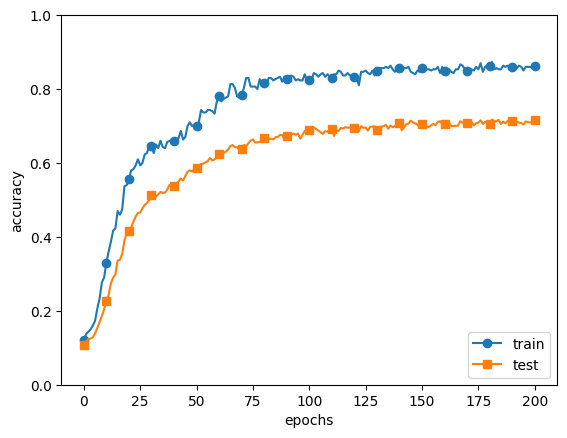

In [48]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) #学習係数lr 0.01の確率的勾配降下法SGDでパラメータ更新

max_epochs = 201
train_size = x_train.shape[0] #300ですね。
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1) #300/100=3ですね。
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 6.4.3 Dropout
まず、正誤表を確認：https://github.com/oreilly-japan/deep-learning-from-scratch/wiki/errata  
「消去した割合」→「消去しなかった割合」  
* 6章 P.195 L.14
* 6章 P.196 L.1
* 6章 P.197 L.15

Dropoutの初出文献（arxiv）：http://arxiv.org/abs/1207.0580

Chainer: https://chainer.org/  
オープンソースの機械学習ライブラリ（開発は2019年で終了）。PyTorchの先駆け。PFNが開発元であった。


In [ ]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True): #train_flgは訓練（学習）かテスト（推論）を判別するフラグ
        if train_flg: #訓練時
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
             #np.random.randは0〜1のランダムな値を生成（一様分布）
             #dropout_ratio=0.2なら、0.2以下はFalse(=0)とする。
            return x * self.mask #maskをxに乗算をすることで一部のニューロンが0に(dropout!)
        else: #テスト時
            return x * (1.0 - self.dropout_ratio) 
             #消去「しなかった」割合を乗算して出力。dropout_ratio=0.2なら、0.8倍に出力をダウンスケールする。

    def backward(self, dout):
        return dout * self.mask
         #forward時に信号を通したニューロンだけ、maskがTrue(=1)なのでそのまま信号を通し、Falseならそこで信号がストップする（0倍）。
         #ReLU関数{x(x>0);0(x<=0)}(p.51)と同じ挙動となる。


train loss:2.3041511655601763
=== epoch:1, train acc:0.12666666666666668, test acc:0.1151 ===
train loss:2.3025677977380767
train loss:2.3008279189526957
train loss:2.298152353077192
=== epoch:2, train acc:0.13, test acc:0.1156 ===
train loss:2.3009984070276386
train loss:2.3003674580628517
train loss:2.300377130597775
=== epoch:3, train acc:0.13, test acc:0.1161 ===
train loss:2.3004339314679556
train loss:2.3015247558379297
train loss:2.30296579514464
=== epoch:4, train acc:0.13, test acc:0.1157 ===
train loss:2.300037799719406
train loss:2.301975409817345
train loss:2.2997180885123414
=== epoch:5, train acc:0.13, test acc:0.1164 ===
train loss:2.3000919381004685
train loss:2.2997460775297354
train loss:2.2975985105096557
=== epoch:6, train acc:0.13333333333333333, test acc:0.1158 ===
train loss:2.3040441714690374
train loss:2.2998237192063793
train loss:2.294597728868229
=== epoch:7, train acc:0.13333333333333333, test acc:0.1159 ===
train loss:2.298236542128595
train loss:2.3013092

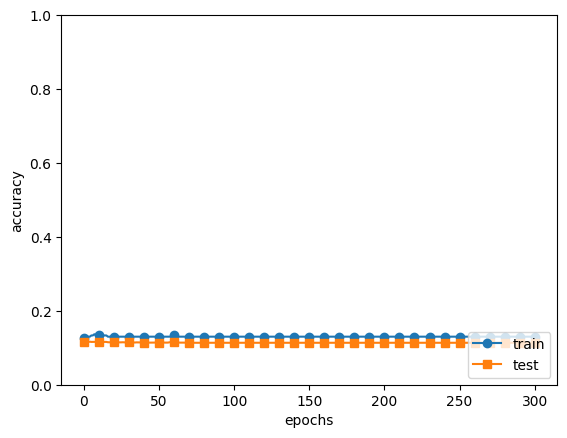

In [53]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.4
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio) #network = MultiLayerNetExtendの構成のなかに、layersからclass Dropoutが渡されている。
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 6.5 ハイパーパラメータの検証
## ハイパーパラメータ(hyper-parameter)とは?
p.109も踏まえると...重みやバイアスといった訓練データを用いた学習から自動的に得られるパラメータとは異なり、人の手によって設定されるパラメータのこと。  
例えば、各層のニューロンの数、バッチサイズ、学習係数、Weight decayでのλ、（先ほどやったばかりの）Dropout ratioなど。   
これらは適切な値に設定しなければ、性能の悪いモデルになってしまう。

## 6.5.1 検証データ
**効率的にハイパーパラメータの値を探索する方法は？**  
最後に行う汎化性能の評価の時に使用するのがテストデータである。なのでテストデータを使ってハイパーパラメータを調整してはいけない。テストデータに対して過学習を起こしてしまう。  
ハイパーパラメータ専用の確認データを、検証データ(validation data)と呼ぶ。  
* 訓練データ：パラメータ（重みやバイアス）の学習に使用  
* 検証データ：ハイパーパラメータの調整に使用
* テストデータ：汎化性能のチェックのために使用  

## 6.5.2 ハイパーパラメータの最適化
**実践的な方法（実践者の知恵）**  
1. 大まかに範囲を設定し（対数スケールで指定）  
! ランダムにサンプリングして探索する方が良いことが知られている
2. ランダムサンプリング
3. 検証データで認識精度を評価（ただし見切りを早くするためにepochは小さく）
4. 100回ほど2-3を繰り返し、ハイパーパラメーターの範囲を狭める


# 6.5.3 ハイパーパラメーター最適化の実装

val acc:0.69 | lr:0.007, weight decay:6.345270132445535e-06
val acc:0.77 | lr:0.007, weight decay:6.117353053734494e-07
val acc:0.69 | lr:0.007, weight decay:1.0661300333553078e-08
val acc:0.68 | lr:0.007, weight decay:5.364139571125984e-08
val acc:0.66 | lr:0.007, weight decay:2.836769285561256e-07
val acc:0.66 | lr:0.007, weight decay:2.4143738793000935e-06
val acc:0.78 | lr:0.007, weight decay:7.487551874212574e-05
val acc:0.67 | lr:0.007, weight decay:5.589112024894272e-06
val acc:0.74 | lr:0.007, weight decay:6.078227050441296e-07
val acc:0.62 | lr:0.007, weight decay:6.060642982788881e-08
val acc:0.59 | lr:0.007, weight decay:8.697616953153824e-07
val acc:0.75 | lr:0.007, weight decay:1.5911550531712915e-07
val acc:0.79 | lr:0.007, weight decay:3.441645054856479e-05
val acc:0.67 | lr:0.007, weight decay:1.8642115919886573e-07
val acc:0.77 | lr:0.007, weight decay:2.487735350143533e-05
val acc:0.75 | lr:0.007, weight decay:4.789105131735338e-08
val acc:0.75 | lr:0.007, weight deca

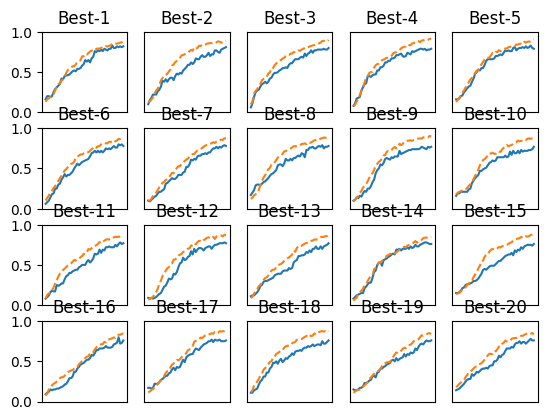

In [55]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20 #訓練データから20%程度を検証データ(validation data)として分離させる。
validation_num = int(x_train.shape[0] * validation_rate) #validation rateに基づいた検証データの数
x_train, t_train = shuffle_dataset(x_train, t_train) #訓練データ（検証データはまだ未分離）をシャッフル
x_val = x_train[:validation_num] #先頭のデータセットから検証データへ
t_val = t_train[:validation_num] #先頭のデータセットから検証データへ
x_train = x_train[validation_num:] #残りは訓練データ
t_train = t_train[validation_num:] #残りは訓練データ


def __train(lr, weight_decay, epocs=50): #epoch=50と小さめに設定
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索するハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 0.007
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


In [57]:
rd = np.random.uniform(-8, -4)
wd =   10 ** rd
print (rd)
print (wd)

-6.719631745019758
1.9070771165352965e-07


val acc:0.26 | lr:0.0019002619441178944, weight decay:6.485162305714022e-08
val acc:0.37 | lr:0.00134553080573273, weight decay:5.6612992798527416e-08
val acc:0.6 | lr:0.0035595354517244703, weight decay:4.265536620956065e-08
val acc:0.24 | lr:0.00104099654189616, weight decay:1.5214227908031988e-08
val acc:0.82 | lr:0.006847850394169302, weight decay:5.0739942549428276e-08
val acc:0.37 | lr:0.0017728333092325598, weight decay:8.041814015900073e-08
val acc:0.3 | lr:0.0019650698565440534, weight decay:2.0372140782942084e-08
val acc:0.45 | lr:0.002900359586633841, weight decay:2.9775728433186904e-08
val acc:0.71 | lr:0.006881124599476767, weight decay:2.2811981771167584e-07
val acc:0.56 | lr:0.005867768401820665, weight decay:5.816316769164613e-08
val acc:0.34 | lr:0.002192836333041122, weight decay:4.4670346450793486e-07
val acc:0.52 | lr:0.003083011293739099, weight decay:6.358998726360305e-08
val acc:0.25 | lr:0.001435046917169891, weight decay:1.606235635270719e-07
val acc:0.55 | lr:

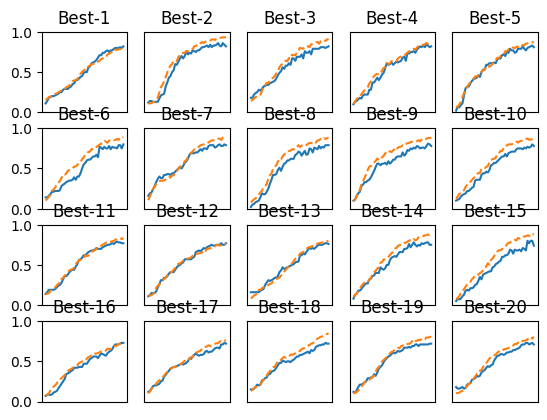

In [46]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20 #訓練データから20%程度を検証データ(validation data)として分離させる。
validation_num = int(x_train.shape[0] * validation_rate) #validation rateに基づいた検証データの数
x_train, t_train = shuffle_dataset(x_train, t_train) #訓練データ（検証データはまだ未分離）をシャッフル
x_val = x_train[:validation_num] #先頭のデータセットから検証データへ
t_val = t_train[:validation_num] #先頭のデータセットから検証データへ
x_train = x_train[validation_num:] #残りは訓練データ
t_train = t_train[validation_num:] #残りは訓練データ


def __train(lr, weight_decay, epocs=50): #epoch=50と小さめに設定
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索するハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -6)
    lr = 10 ** np.random.uniform(-3, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


# ベイズ最適化（Bayesian optimization）
https://arxiv.org/abs/1206.2944  
人間の手による試行錯誤に代わり、ベイズ最適化（Gaussian Processによる）が、より効率的かつ高性能にハイパーパラメータを最適化できる。  
>P(A∣B)P(B) = P(A∩B) = P(B∣A)P(A)  
より得られる、  
P(A∣B) = P(B∣A)P(A)/P(B) (ただしP(B)>0)  
​をベイズの定理という。
書き換えると  
P(A∣B) = P(A)* [P(B∣A)/P(B)]  